# Tournament Winner Classification
Goal: Develop a model that predict the probability that a certain player has to win a PGA tournament versus the rest of the field.

In [19]:
import sqlite3
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBClassifier, XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Tournament_Winner/Data/PGA_SQL_DB/PGA.db')

## Pull Data from Database and Prepare for Training
- This raw data was scrape and aggregated by the data pipeline in the Data folder and uploaded to a SQL database.
- Tournament adjustments, historical weighting, and field standardization were implemented in SQL and python functions found in the SQL database. 

### Pull Data

In [29]:
df = pd.read_sql_query("SELECT * FROM FINAL_MODEL_DATA", conn)
df.insert(3, 'PLAYER_ID', pd.factorize(df['PLAYER_NAME'])[0])
df

,TOURNAMENT_NAME,TOURNAMENT_ID,PLAYER_NAME,PLAYER_ID,TOURNAMENT_DATE,POSITION,STANDARD_POSITION,FINISH,LENGTH,ELEVATION,...,HL_100_R4_SCR,HL_200_R4_SCR,T12_EARNINGS,T12_FED_EX_PTS,T12_WINS,T12_TOP_5,T12_TOP_10,T12_TOP_20,T12_MADE_CUTS,T12_APPERANCES
0,2024 ZOZO CHAMPIONSHIP,1,Adam Schenk,0,2024-10-24 00:00:00,67.0,0.868421,0,7079,82.0,...,0.392838,-0.070481,0.040106,0.099459,-0.153705,0.706063,0.204243,0.813545,-0.157123,1.621514
1,2024 ZOZO CHAMPIONSHIP,1,Adam Svensson,1,2024-10-24 00:00:00,46.0,0.592105,0,7079,82.0,...,0.580869,0.446211,-0.112340,-0.089145,-0.153705,-0.353204,0.292781,-0.209746,1.143727,1.244304
2,2024 ZOZO CHAMPIONSHIP,1,Andrew Novak,2,2024-10-24 00:00:00,16.0,0.197368,0,7079,82.0,...,-0.432815,-0.271889,-0.023209,0.024017,-0.153705,-0.353204,1.089615,1.632178,0.766060,-0.264537
3,2024 ZOZO CHAMPIONSHIP,1,Andrew Putnam,3,2024-10-24 00:00:00,27.0,0.342105,0,7079,82.0,...,-0.263804,-0.286968,-0.182216,-0.190473,-0.153705,-0.353204,-0.504054,-0.005088,1.017838,0.489883
4,2024 ZOZO CHAMPIONSHIP,1,Beau Hossler,4,2024-10-24 00:00:00,56.0,0.723684,0,7079,82.0,...,1.507123,0.946162,-0.265548,-0.265703,-0.153705,-0.353204,-0.504054,-0.122036,0.226537,0.867093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767,2017 Masters Tournament,10,Webb Simpson,119,2017-04-06 00:00:00,NaN,-1.000000,0,7435,44.0,...,0.987376,0.987376,-0.025991,-0.006533,-0.103695,-0.103695,-0.210857,-0.261197,2.030237,1.441326
11768,2017 Masters Tournament,10,William McGirt,551,2017-04-06 00:00:00,22.0,0.403846,0,7435,44.0,...,0.000000,0.000000,-0.200392,-0.209058,-0.103695,-0.103695,-0.210857,-0.261197,-0.487257,-0.686346
11769,2017 Masters Tournament,10,Yuta Ikeda,947,2017-04-06 00:00:00,NaN,-1.000000,0,7435,44.0,...,0.000000,0.000000,-0.200392,-0.209058,-0.103695,-0.103695,-0.210857,-0.261197,-0.487257,-0.686346
11770,2017 Masters Tournament,10,Zach Johnson,205,2017-04-06 00:00:00,NaN,-1.000000,0,7435,44.0,...,0.000000,0.000000,-0.200392,-0.209058,-0.103695,-0.103695,-0.210857,-0.261197,-0.487257,-0.686346


### Prepare for model
- Don't want to use 2017 tournaments for training because not enough historical data
- Use 2 most recent tournaments as a validators

In [30]:
features = ['TOURNAMENT_ID', 'PLAYER_ID', 'LENGTH', 'ELEVATION', 'WIND',
       'HL_100_SG_P', 'HL_100_SG_OTT', 'HL_50_SG_APR', 'HL_200_SG_ATG', 
       'HL_100_R1_SCR', 'HL_100_R2_SCR', 'HL_200_R3_SCR', 'HL_100_R4_SCR',
       'T12_EARNINGS', 'T12_WINS', 'T12_TOP_5', 'T12_TOP_10','T12_TOP_20']
finish_target = 'FINISH'
position_target = 'POSITION'
standard_position_target = 'STANDARD_POSITION'

validation_df = df.loc[(df['TOURNAMENT_NAME'] == "2024 ZOZO CHAMPIONSHIP") | (df['TOURNAMENT_NAME'] == "2024 The Open")]
df = df.loc[(df['TOURNAMENT_DATE'] >= "2019") & (df['TOURNAMENT_NAME'] != "2024 ZOZO CHAMPIONSHIP") & (df['TOURNAMENT_NAME'] != "2024 The Open")]
df

,TOURNAMENT_NAME,TOURNAMENT_ID,PLAYER_NAME,PLAYER_ID,TOURNAMENT_DATE,POSITION,STANDARD_POSITION,FINISH,LENGTH,ELEVATION,...,HL_100_R4_SCR,HL_200_R4_SCR,T12_EARNINGS,T12_FED_EX_PTS,T12_WINS,T12_TOP_5,T12_TOP_10,T12_TOP_20,T12_MADE_CUTS,T12_APPERANCES
77,2024 Wells Fargo Championship,2,Adam Hadwin,77,2024-05-09 00:00:00,52.0,0.761194,0,7558,254.0,...,-1.300569,-1.120239,0.685127,0.604039,-0.304377,2.694293,1.202814,0.446332,0.550004,0.681132
78,2024 Wells Fargo Championship,2,Adam Schenk,0,2024-05-09 00:00:00,64.0,0.940299,0,7558,254.0,...,-0.610286,-0.841568,-0.011292,0.117781,-0.304377,0.113843,0.763113,1.016321,-0.610465,1.839056
79,2024 Wells Fargo Championship,2,Adam Scott,78,2024-05-09 00:00:00,29.0,0.417910,0,7558,254.0,...,-0.146314,-0.259371,-0.166136,-0.057679,-0.304377,-0.824502,-0.262856,0.446332,1.130238,0.681132
80,2024 Wells Fargo Championship,2,Adam Svensson,1,2024-05-09 00:00:00,47.0,0.686567,0,7558,254.0,...,-0.634204,-0.352949,-0.566232,-0.551722,-0.304377,-0.824502,-0.262856,-0.123657,0.550004,0.681132
81,2024 Wells Fargo Championship,2,Akshay Bhatia,79,2024-05-09 00:00:00,42.0,0.611940,0,7558,254.0,...,-0.662078,-0.776613,0.494063,0.971327,4.086026,0.739407,-0.018577,-0.503650,-0.610465,-0.476792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,2019 3M Open,26,Wes Roach,861,2019-07-04 00:00:00,NaN,-1.000000,0,7468,275.0,...,-1.717432,-1.619962,0.804162,1.027931,-0.140816,-0.251624,-0.440435,2.352352,1.752600,-1.078802
8826,2019 3M Open,26,Whee Kim,965,2019-07-04 00:00:00,NaN,-1.000000,0,7468,275.0,...,-0.329739,0.124569,-0.437510,-0.476936,-0.140816,-0.251624,-0.440435,-0.666093,-0.742767,-0.286557
8827,2019 3M Open,26,Will Claxton,966,2019-07-04 00:00:00,NaN,-1.000000,0,7468,275.0,...,0.000000,0.000000,-0.513067,-0.594337,-0.140816,-0.251624,-0.440435,-0.666093,-1.574556,-1.078802
8828,2019 3M Open,26,Wyndham Clark,120,2019-07-04 00:00:00,5.0,0.055556,1,7468,275.0,...,-0.120412,-0.237537,-0.361599,-0.359535,-0.140816,-0.251624,-0.440435,-0.666093,0.089022,-0.286557


### Observe Class Breakdown in Training/Test set

In [6]:
df[finish_target].value_counts()

FINISH
0    8221
1     378
Name: count, dtype: int64

In [7]:
df[position_target].value_counts()

POSITION
35.0    117
41.0    101
23.0    101
13.0     97
9.0      97
       ... 
81.0      8
79.0      7
83.0      5
80.0      3
82.0      2
Name: count, Length: 83, dtype: int64

## Exploratory Data Analysis

### Correlation Analysis for TOP 5 and WIN Groups

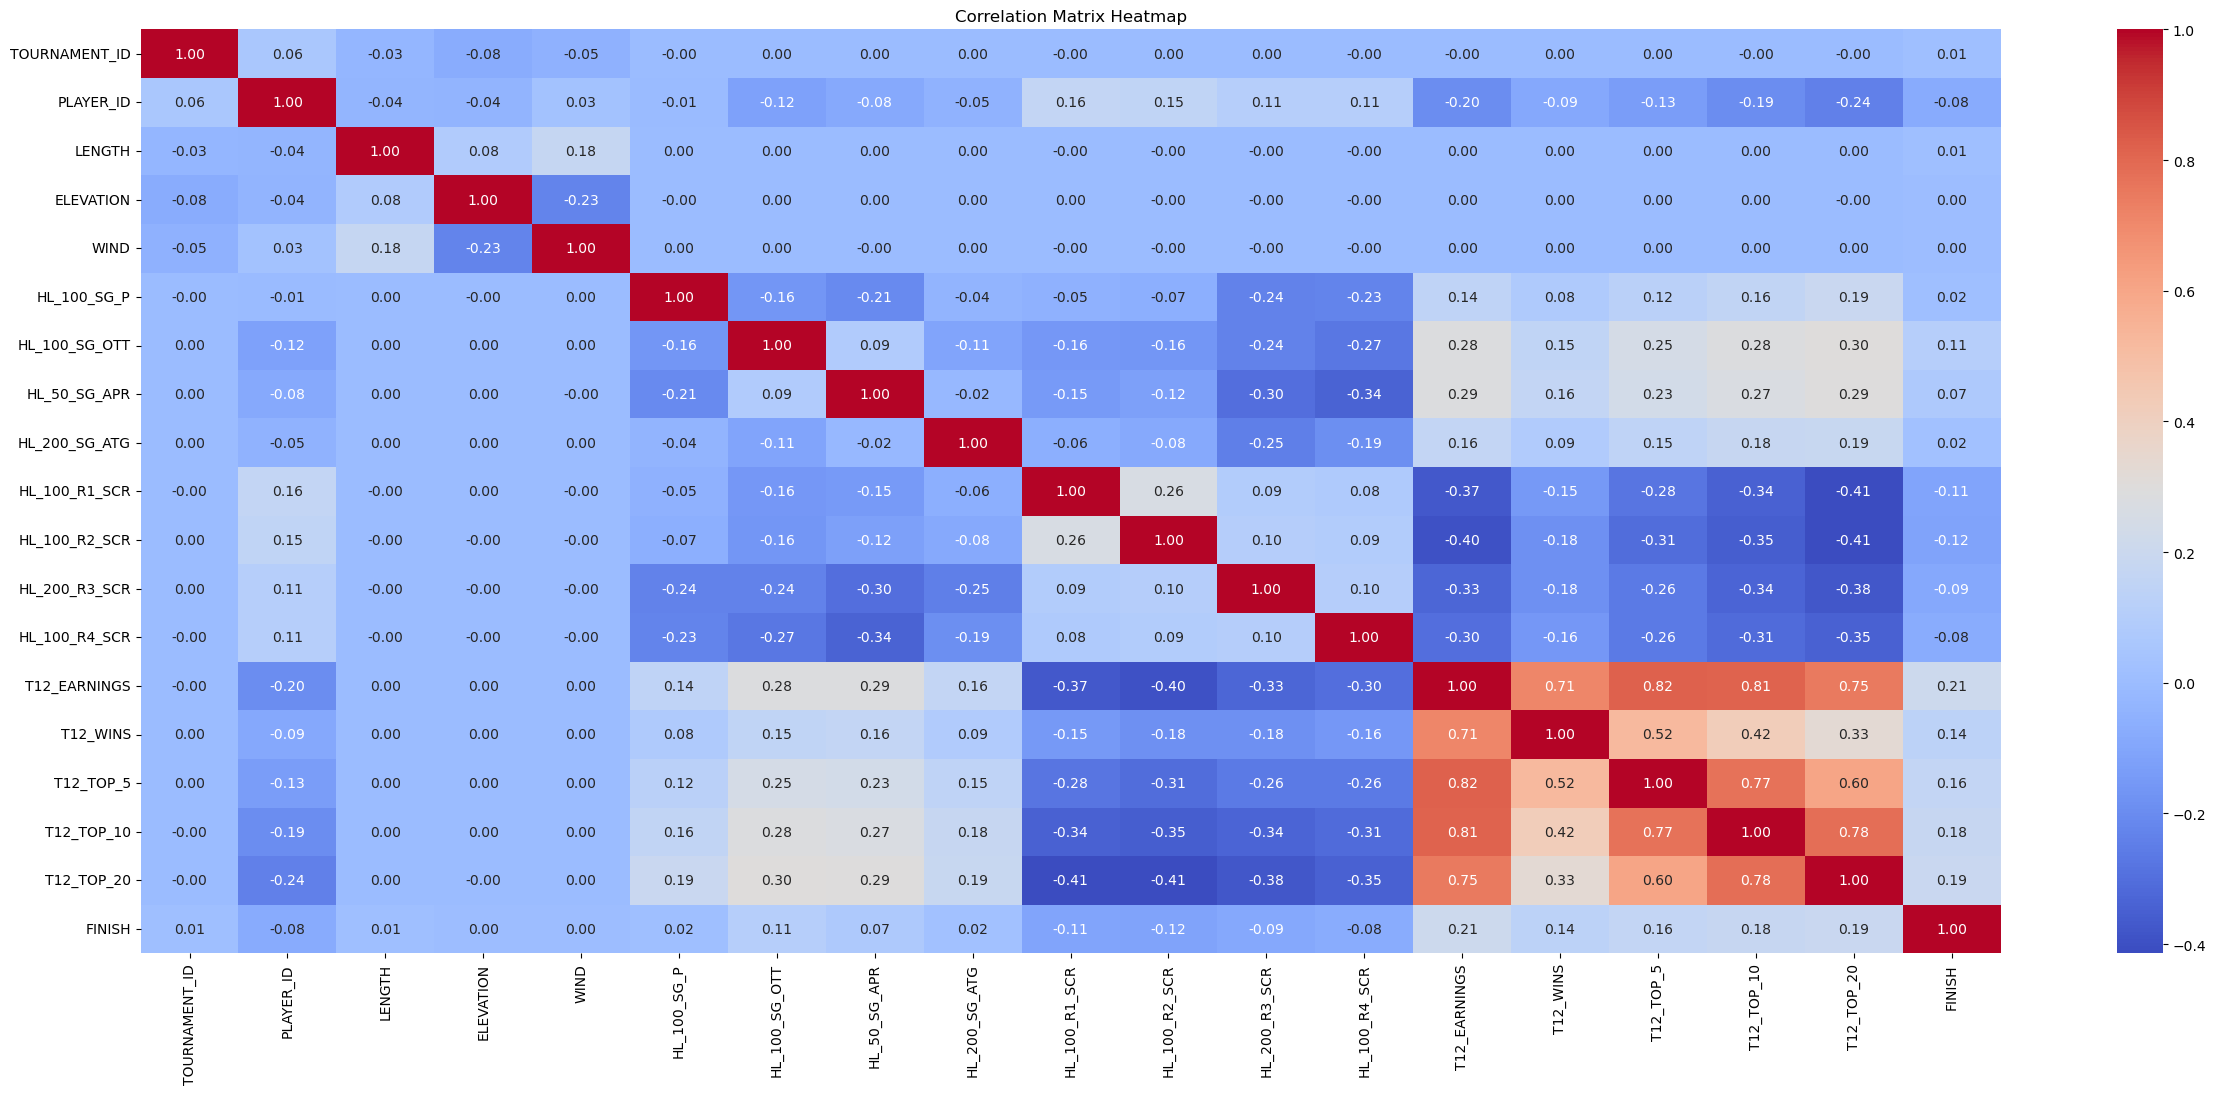

In [9]:
features_and_target = features.copy()
features_and_target.append(finish_target)

# Compute correlation matrix
correlation_matrix = df[features_and_target].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Correlation Analysis for Position Target

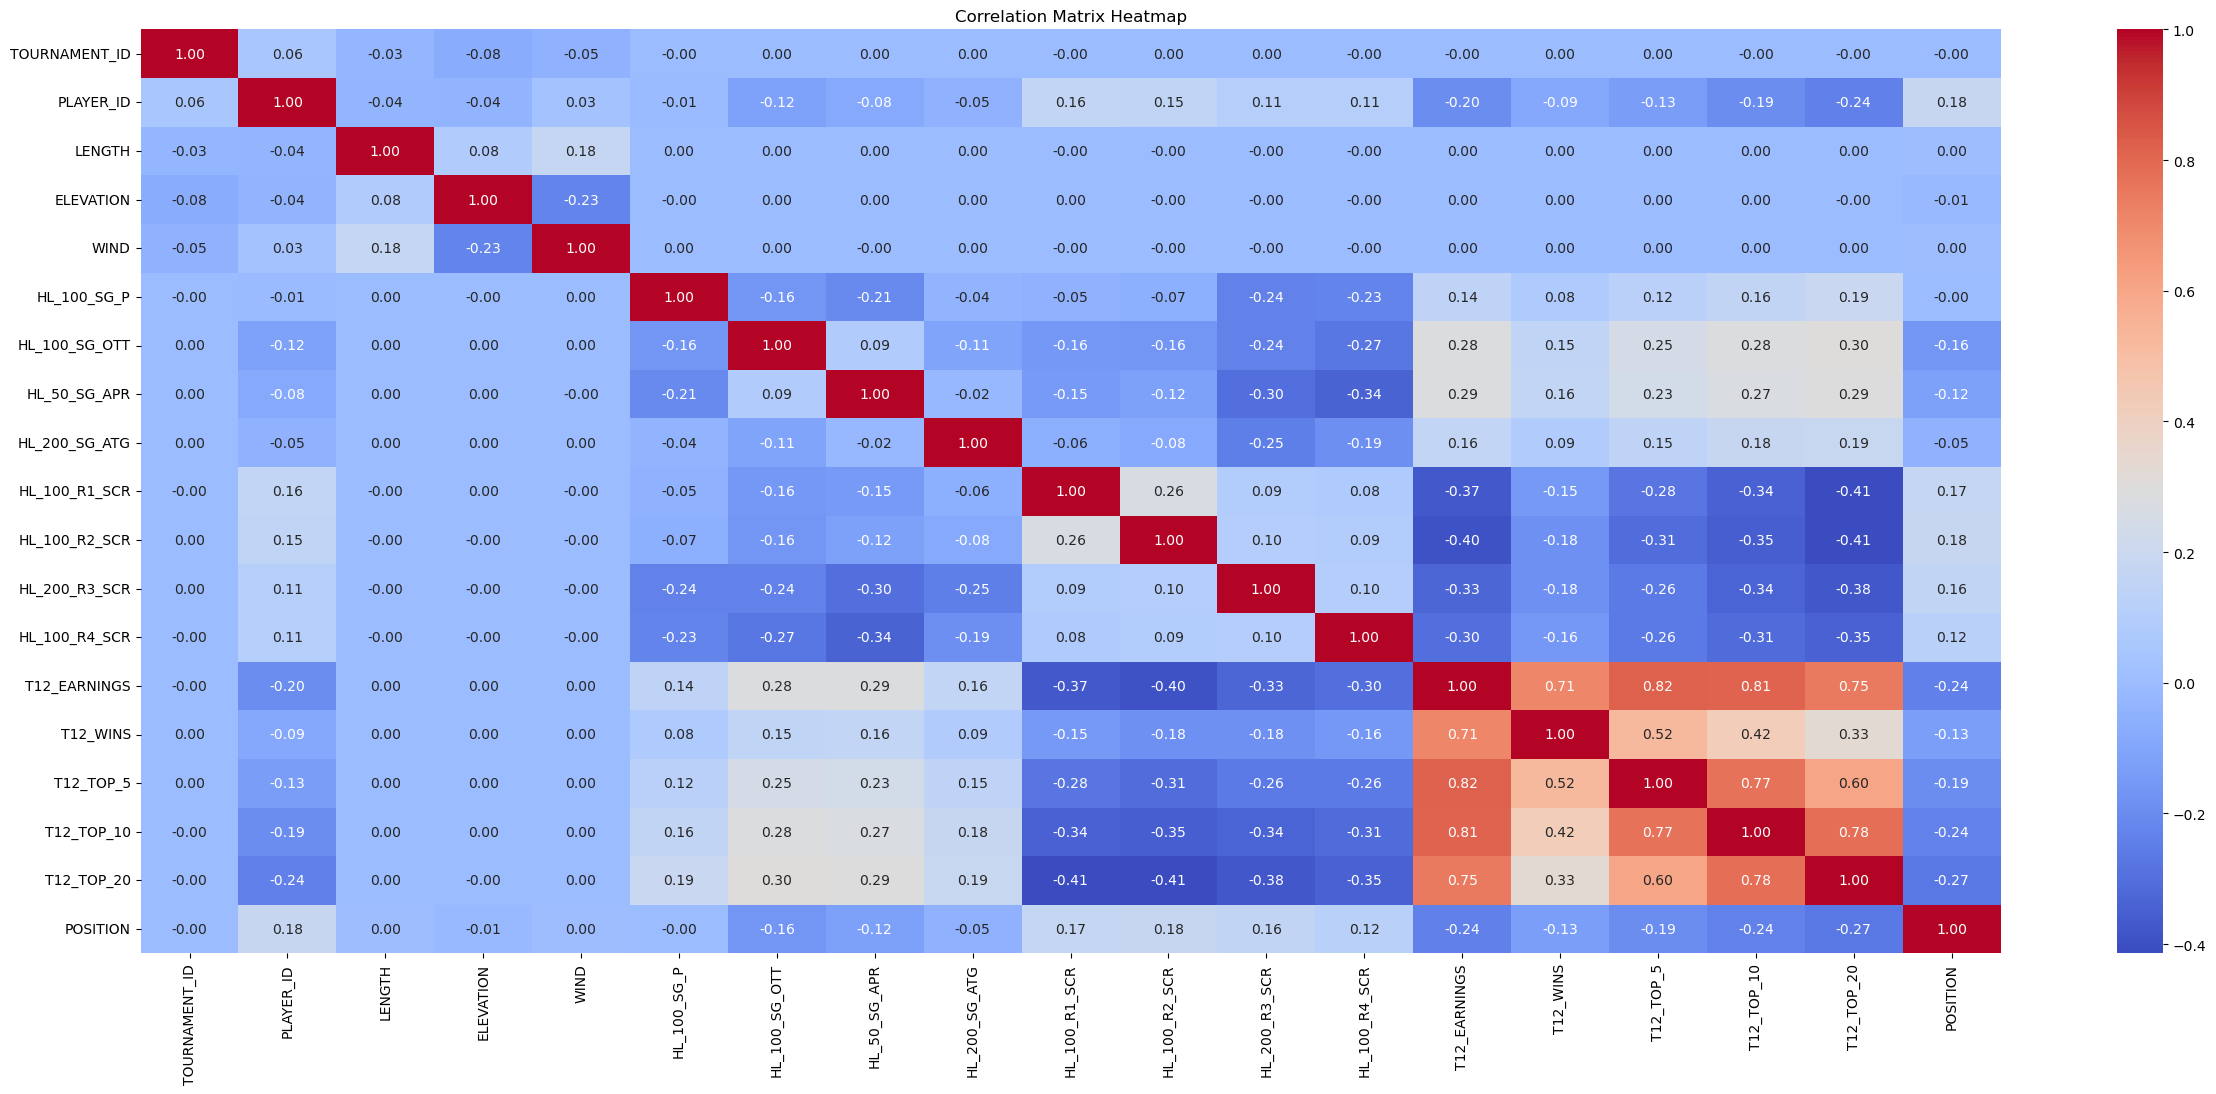

In [11]:
features_and_target = features.copy()
features_and_target.append(position_target)

# Compute correlation matrix
correlation_matrix = df[features_and_target].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

## Build Finish Model
- Goal is to classify players based on there chances to be in the TOP 5 or WIN groups
- To handle severe class imbalance need to weight by class and cross validate with measures like Precision, Recall, F1-score, Precision-Recall AUC
- Sklearn GridSearchCV has precision_weighted, recall_weighted, f1_weighted, average_precision (Precision-Recall AUC)

### XGBoost

In [28]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
scale = df[finish_target].value_counts()[0] / df[finish_target].value_counts()[1]
model = XGBClassifier(scale_pos_weight=scale, objective='binary:logistic')

param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [2, 5, 7],
    'n_estimators': [40, 50, 60],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.4, 0.5, 0.6]
}

#f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
cv = GridSearchCV(estimator=model, param_grid=param_grid, 
    scoring='average_precision', cv=kf, n_jobs=-1, return_train_score=True)
cv.fit(df[features], df[finish_target])

# Convert results into a DataFrame
cv_results = pd.DataFrame(cv.cv_results_)

# Get best model index
best_model_index = cv.best_index_
best_model = cv.best_estimator_

# Retrieve Training and Testing MSE
train_score = cv_results.loc[best_model_index, 'mean_train_score']
test_score = cv_results.loc[best_model_index, 'mean_test_score']
params = cv_results.loc[best_model_index, 'params']

# Retrieve Feature Importance
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Best Hyperparameters:", params)
print("Feature Importance", importance_df)
print("Mean Training Score:", train_score)
print("Mean Testing Score:", test_score)

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 40, 'subsample': 0.6}
Feature Importance           Feature  Importance
13   T12_EARNINGS    0.129895
17     T12_TOP_20    0.116313
16     T12_TOP_10    0.078124
10  HL_100_R2_SCR    0.052834
11  HL_200_R3_SCR    0.051847
9   HL_100_R1_SCR    0.051527
1       PLAYER_ID    0.050253
6   HL_100_SG_OTT    0.048562
0   TOURNAMENT_ID    0.045595
14       T12_WINS    0.045587
15      T12_TOP_5    0.045264
7    HL_50_SG_APR    0.044611
3       ELEVATION    0.043730
12  HL_100_R4_SCR    0.042848
8   HL_200_SG_ATG    0.042397
5     HL_100_SG_P    0.040086
4            WIND    0.037633
2          LENGTH    0.032895
Mean Training Score: 0.3400382089266046
Mean Testing Score: 0.16038049204086707


## Build Position Model
- The goal of this model is predict their finish 1 to as many players in the field (If two players were to tie they would have the same position)

In [34]:
df = df.loc[df[position_target].notna()]
df

,TOURNAMENT_NAME,TOURNAMENT_ID,PLAYER_NAME,PLAYER_ID,TOURNAMENT_DATE,POSITION,STANDARD_POSITION,FINISH,LENGTH,ELEVATION,...,HL_100_R4_SCR,HL_200_R4_SCR,T12_EARNINGS,T12_FED_EX_PTS,T12_WINS,T12_TOP_5,T12_TOP_10,T12_TOP_20,T12_MADE_CUTS,T12_APPERANCES
77,2024 Wells Fargo Championship,2,Adam Hadwin,77,2024-05-09 00:00:00,52.0,0.761194,0,7558,254.0,...,-1.300569,-1.120239,0.685127,0.604039,-0.304377,2.694293,1.202814,0.446332,0.550004,0.681132
78,2024 Wells Fargo Championship,2,Adam Schenk,0,2024-05-09 00:00:00,64.0,0.940299,0,7558,254.0,...,-0.610286,-0.841568,-0.011292,0.117781,-0.304377,0.113843,0.763113,1.016321,-0.610465,1.839056
79,2024 Wells Fargo Championship,2,Adam Scott,78,2024-05-09 00:00:00,29.0,0.417910,0,7558,254.0,...,-0.146314,-0.259371,-0.166136,-0.057679,-0.304377,-0.824502,-0.262856,0.446332,1.130238,0.681132
80,2024 Wells Fargo Championship,2,Adam Svensson,1,2024-05-09 00:00:00,47.0,0.686567,0,7558,254.0,...,-0.634204,-0.352949,-0.566232,-0.551722,-0.304377,-0.824502,-0.262856,-0.123657,0.550004,0.681132
81,2024 Wells Fargo Championship,2,Akshay Bhatia,79,2024-05-09 00:00:00,42.0,0.611940,0,7558,254.0,...,-0.662078,-0.776613,0.494063,0.971327,4.086026,0.739407,-0.018577,-0.503650,-0.610465,-0.476792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8822,2019 3M Open,26,Troy Merritt,199,2019-07-04 00:00:00,7.0,0.083333,0,7468,275.0,...,0.483074,0.645909,-0.424002,-0.500416,-0.140816,-0.251624,-0.440435,-0.666093,-0.243694,0.109566
8823,2019 3M Open,26,Tyrone Van Aswegen,964,2019-07-04 00:00:00,53.0,0.722222,0,7468,275.0,...,0.863269,0.875721,-0.513067,-0.594337,-0.140816,-0.251624,-0.440435,-0.666093,-1.574556,-1.078802
8824,2019 3M Open,26,Viktor Hovland,118,2019-07-04 00:00:00,13.0,0.166667,0,7468,275.0,...,-1.487759,-1.481596,-0.513067,-0.594337,-0.140816,-0.251624,-0.440435,2.352352,1.752600,-1.078802
8828,2019 3M Open,26,Wyndham Clark,120,2019-07-04 00:00:00,5.0,0.055556,1,7468,275.0,...,-0.120412,-0.237537,-0.361599,-0.359535,-0.140816,-0.251624,-0.440435,-0.666093,0.089022,-0.286557


In [38]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
model = XGBRegressor(objective='reg:absoluteerror')

param_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [3, 4, 5],
    'n_estimators': [80, 100, 120],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

#f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
cv = GridSearchCV(estimator=model, param_grid=param_grid, 
    scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, return_train_score=True)
cv.fit(df[features], df[position_target])

# Convert results into a DataFrame
cv_results = pd.DataFrame(cv.cv_results_)

# Get best model index
best_model_index = cv.best_index_
best_model = cv.best_estimator_

# Retrieve Training and Testing MSE
train_score = cv_results.loc[best_model_index, 'mean_train_score']
test_score = cv_results.loc[best_model_index, 'mean_test_score']
params = cv_results.loc[best_model_index, 'params']

# Retrieve Feature Importance
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Best Hyperparameters:", params)
print("Feature Importance", importance_df)
print("Mean Training Score:", train_score)
print("Mean Testing Score:", test_score)

/Users/nickospelt/anaconda3/envs/pga_model/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 80, 'subsample': 0.95}
Feature Importance           Feature  Importance
17     T12_TOP_20    0.161584
13   T12_EARNINGS    0.145901
1       PLAYER_ID    0.062850
11  HL_200_R3_SCR    0.059485
14       T12_WINS    0.048178
16     T12_TOP_10    0.048081
6   HL_100_SG_OTT    0.047410
9   HL_100_R1_SCR    0.045247
12  HL_100_R4_SCR    0.044392
10  HL_100_R2_SCR    0.044015
5     HL_100_SG_P    0.042944
8   HL_200_SG_ATG    0.041592
7    HL_50_SG_APR    0.038662
3       ELEVATION    0.036262
15      T12_TOP_5    0.036173
4            WIND    0.035868
2          LENGTH    0.030910
0   TOURNAMENT_ID    0.030447
Mean Training Score: -14.866233496804437
Mean Testing Score: -16.729507945390942
